In [1]:
import tensorflow as tf
print(tf.__version__)

import tensorflow_probability as tfp
print('tfp version', tfp.__version__)
tfd = tfp.distributions
tfb = tfp.bijectors

import h5py
import healpy as hp

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax

import jaxlib

import numpy as np

print('jax version: ', jax.__version__)
print('jaxlib version: ', jaxlib.__version__)


# tensorflow-prob VANILLA
tfd = tfp.distributions
tfb = tfp.bijectors

# # tensorflow-prob-JAX
import tensorflow_probability.substrates.jax as tfpj

tfdj = tfpj.distributions
tfbj = tfpj.bijectors

# matplotlib stuff
import matplotlib.pyplot as plt

# flax import
import flax.linen as nn
import optax

# for imnn
import imnn
import imnn.lfi
from imnn.utils import value_and_jacrev, value_and_jacfwd


# powerbox
import powerbox_jax as pbj
import powerbox as pbox

rng = random.PRNGKey(2)

2.7.0
tfp version 0.13.0
jax version:  0.2.21
jaxlib version:  0.1.69


In [4]:
def gen_rearr(nside):
    # recursive funtion for finding the right 
    # ordering for the nested pixels 
    if (nside==1):
        return np.array([0,1,2,3])
    else:
        smaller = np.reshape(gen_rearr(nside-1),(2**(nside-1),2**(nside-1)))
        npixsmaller = 2**(2*(nside-1))
        top = np.concatenate((smaller,smaller+npixsmaller),axis=1)
        bot = np.concatenate((smaller+2*npixsmaller,smaller+3*npixsmaller),axis=1)
        whole = np.concatenate((top,bot))
        return whole.flatten()

In [5]:
# "GLOBAL" parameters
N_NU_OUT = 64

#(NU_L,NU_H) = (1,N_NU_OUT*NU_AVG)
N_SKIP = 1
N_FREQS = 690
N_FREQ_BINS = 4
#assert(((NU_H-NU_L + 1)%NU_AVG) ==0)
MAP_NSIDE = 256
SIM_NSIDE = MAP_NSIDE
WINDOW_NSIDE = 4
NUM_SIMS = 1
# resolution of the outgoing window
NPIX_WINDOW = (MAP_NSIDE/WINDOW_NSIDE)**2
# actual side length of window
WINDOW_LENGTH = int(np.sqrt(NPIX_WINDOW))

# rearrange indices
rearr = gen_rearr(int(np.log2(MAP_NSIDE/WINDOW_NSIDE)))
nwinds = int(hp.nside2npix(WINDOW_NSIDE))


# sim specs
mypol = 0
nustart = 0


index_arr = np.load('rearr_nside4.npy', allow_pickle=False)

In [6]:
# first visualize data
datapath = '/data80/makinen/hirax_sims/draco_output/'

In [7]:
# first some additional packages that we'll need
import healpy as hp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def map_to_tiles(input_map, index_array, n_nu=None, n_nu_avg=3, n_nu_out=64, output_shape=None):

    # rearrange indices
    rearr = gen_rearr(int(np.log2(MAP_NSIDE/WINDOW_NSIDE)))
    nwinds = int(hp.nside2npix(WINDOW_NSIDE))
    
    
    # allocate the output array
    if output_shape is None:
        map_out = np.zeros(input_map.shape)
    else:
        map_out = np.zeros(output_shape)

    # get the array indices in the RING formulation
    inds = np.arange(hp.nside2npix(MAP_NSIDE))
    # transfer these to what they would be in the NESTED formulation  
    inds_nest = hp.ring2nest(MAP_NSIDE,inds) # hp.nest2ring(MAP_NSIDE,inds)


    for PIX_SELEC in np.arange(hp.nside2npix(WINDOW_NSIDE)):
        # get the indices of the pixels which actually are in the larger pixel
        inds_in = np.where((inds_nest//NPIX_WINDOW)==PIX_SELEC)
        to_rearr_inds = inds_nest[inds_in] - PIX_SELEC*NPIX_WINDOW
        to_rearr = input_map[inds_in]
        to_rearr = (to_rearr[np.argsort(to_rearr_inds)])[rearr]
        to_rearr = np.reshape(to_rearr,(WINDOW_LENGTH,WINDOW_LENGTH,n_nu_out))
        ind = (0)*nwinds + PIX_SELEC
        map_out[ind] = to_rearr
                  
    return map_out
    
    

def pca_subtraction(input_map, n_comp, index_array, n_nu=None, 
                    nu_arr=None, nu_start=0, n_nu_out=64, n_nu_avg=3, output_shape=None):

    # rearrange indices
    rearr = gen_rearr(int(np.log2(MAP_NSIDE/WINDOW_NSIDE)))
    nwinds = int(hp.nside2npix(WINDOW_NSIDE))
  
    if nu_arr is not None:
        print('working in frequency range ', nu_arr[nu_start], '--', 
                                nu_arr[nu_start + (n_nu*n_nu_avg)-1], 
                ' MHz')
      
    # initialize the PCA algorithm
    pca = PCA()
    
    # allocate the output array
    if output_shape is None:
        pca_reduced_out = np.zeros(input_map.shape)
    else:
        pca_reduced_out = np.zeros(output_shape)

  
    # do PCA removal of n_comp components
    pca.fit(input_map)
    obs_pca = pca.transform(input_map)
    ind_arr = np.reshape(np.arange(np.prod(np.array(obs_pca.shape))),obs_pca.shape)

  
    mask = np.ones(obs_pca.shape)
    for i in range(n_comp, obs_pca.shape[1]):
        mask[ind_arr%obs_pca.shape[1]==i] = 0
        
    obs_pca = obs_pca*mask
    obs_pca_red = pca.inverse_transform(obs_pca)
    print("Now I'm doing the minimum subtraction...")
    print("...removing the first %d principal components"%(n_comp))
    obs_pca_red = input_map - obs_pca_red

    # get the array indices in the RING formulation
    inds = np.arange(hp.nside2npix(MAP_NSIDE))
    # transfer these to what they would be in the NESTED formulation  
    inds_nest = hp.ring2nest(MAP_NSIDE,inds) # hp.nest2ring(MAP_NSIDE,inds)


    for PIX_SELEC in np.arange(hp.nside2npix(WINDOW_NSIDE)):
        # get the indices of the pixels which actually are in the larger pixel
        inds_in = np.where((inds_nest//NPIX_WINDOW)==PIX_SELEC)
        to_rearr_inds = inds_nest[inds_in] - PIX_SELEC*NPIX_WINDOW
        to_rearr = obs_pca_red[inds_in]
        to_rearr = (to_rearr[np.argsort(to_rearr_inds)])[rearr]
        to_rearr = np.reshape(to_rearr,(WINDOW_LENGTH,WINDOW_LENGTH,n_nu_out))
        ind = (0)*nwinds + PIX_SELEC
        pca_reduced_out[ind] = to_rearr
                  
    return pca_reduced_out

In [8]:
def load_data(datapath, pol, n_nu, num_sets=5):
    cosmo = []
    fg = []

    for i in range(num_sets):
        f_fg = h5py.File(datapath + 'mlmap_galaxy_%d.h5'%(i), 'r')
        f_cosmo = h5py.File(datapath + 'mlmap_21cm_%d.h5'%(i), 'r')


        fg.append(np.array(f_fg['map'])[nustart:N_NU_OUT, pol, :].T)   # put freqs last
        cosmo.append(np.array(f_cosmo['map'])[nustart:N_NU_OUT, pol, :].T)
    
    cosmo = np.array(cosmo)
    fg = np.array(fg)
    
    return cosmo, fg

In [10]:
cosmo, fg = load_data(datapath, 0, 64)

(5, 786432, 64)

In [11]:
# now do PCA subtraction and tile rearrangement

obs = cosmo + fg

n_side = 4   # data arrangement parameter
n_voxels = hp.nside2npix(4) 
print('we have %d voxels per sky simulation'%(n_voxels))

print("we\'re working with %d sky simulations"%(obs.shape[0]))
pca3 = []

for i,sky in enumerate(obs):
# do the PCA subtraction for each map separately
    print('starting PCA subtraction for sky %d'%(i+1))
    pca3.append(pca_subtraction(sky, 3, index_arr, n_nu=N_NU_OUT, 
                    nu_arr=None, nu_start=0, n_nu_out=N_NU_OUT, n_nu_avg=1, output_shape=(192, 64, 64, N_NU_OUT)))
    
pca3 = np.array(pca3)
print('I put the PCA-3 subtraction put back into this shape : ', pca3.shape)

we have 192 voxels per sky simulation
we're working with 5 sky simulations
starting PCA subtraction for sky 1
Now I'm doing the minimum subtraction...
...removing the first 3 principal components
starting PCA subtraction for sky 2
Now I'm doing the minimum subtraction...
...removing the first 3 principal components
starting PCA subtraction for sky 3
Now I'm doing the minimum subtraction...
...removing the first 3 principal components
starting PCA subtraction for sky 4
Now I'm doing the minimum subtraction...
...removing the first 3 principal components
starting PCA subtraction for sky 5
Now I'm doing the minimum subtraction...
...removing the first 3 principal components
I put the PCA-3 subtraction put back into this shape :  (5, 192, 64, 64, 64)


In [12]:
# rerrange cosmo and fg tiles
cosmo_tiles = np.array([map_to_tiles(c, index_arr, n_nu=N_NU_OUT, n_nu_avg=1, output_shape=(192, 64, 64, N_NU_OUT)) for c in cosmo])
fg_tiles = np.array([map_to_tiles(f, index_arr, n_nu=N_NU_OUT, n_nu_avg=1, output_shape=(192, 64, 64, N_NU_OUT)) for f in fg])

In [13]:
np.concatenate(cosmo_tiles[-1:]).shape

(192, 64, 64, 64)

In [ ]:
# data loader script
"""Data loading utils for Xander regression training."""

import pathlib
import jraph
import numpy as np
import pandas as pd


class DataReader:
    """Data Reader for HIRAX-type simulations"""

    def __init__(self, 
            datapath,
            batch_size=24,
            split_idx=3):

    
    """Initializes the data reader by loading in data."""
    
    
        
        
        self.X_train = np.concatenate(pca3[:split_idx])
        self.X_val = np.concatenate(pca3[split_idx:])
        
        
        self.Y_train = np.concatenate(cosmo_tiles[:split_idx])
        self.Y_val = np.concatenate(cosmo_tiles[split_idx:])   

        # set training mode (defaults to "train")
        self.switch_training_mode()
        self._batch_size = batch_size

        self._repeat = False
        self._batch_size = batch_size
        self._generator = self._make_generator()


    def switch_training_mode(self, mode='train', verbose=False):
        if mode == 'train':
            if verbose:
                print('setting reader to training mode')

            self.Y_dat = self.Y_train
            self.X_dat = self.X_train

        else:
            if verbose:
              print('setting reader to validation mode')

            self.Y_dat = self.Y_val
            self.X_dat = self.X_val

        # re-compute node numbers
        self.get_node_nums()

    
  @property
  def total_num_graphs(self):
    return len(self._n_node)

  def repeat(self):
    self._repeat = True

  def __iter__(self):
    return self

  def __next__(self):
    graphs = []
    labels = []
    for _ in range(self._batch_size):
      graph, label = next(self._generator)
      graphs.append(graph)
      labels.append(label)
    return jraph.batch(graphs), np.concatenate([labels], axis=0)


  def get_graph_by_idx(self, idx):
    """Gets a graph by an integer index."""
    # Gather the graph information
    
    label = self.Y_dat[idx] #self._labels[idx]

    # get the numbe of nodes
    n_node = self._n_node[idx]

    # get the (dt,de,dx,dy) node data
    node_dat = self._make_event_set(self.X_dat[idx])


    return 

  def _make_generator(self):
    """Makes a single example generator of the loaded OGB data."""
    idx = 0
    while True:
      # If not repeating, exit when we've cycled through all the graphs.
      # Only return graphs within the split.
      if not self._repeat:
        if idx == self.total_num_graphs:
          return
      else:
        # This will reset the index to 0 if we are at the end of the dataset.
        idx = idx % self.total_num_graphs
      #if idx not in self._split_idx:
      idx += 1
        #continue
      graph, label = self.get_graph_by_idx(idx)
      idx += 1
      yield graph, label

# unet code

In [14]:
from typing import Any, Callable, Sequence, Optional
from flax.core import freeze, unfreeze
from functools import partial

In [15]:
class AsinhLayer(nn.Module):
    bias_init: Callable = nn.initializers.zeros
    a_init: Callable = nn.initializers.ones
    b_init: Callable = nn.initializers.ones
    c_init: Callable = nn.initializers.zeros
    d_init: Callable = nn.initializers.zeros
    
    @nn.compact
    def __call__(self, inputs):

        a = self.param('a', self.a_init, (1,))
        b = self.param('b', self.b_init, (1,))
        c = self.param('c', self.c_init, (1,))
        d = self.param('d', self.d_init, (1,)) 

        y = a*jnp.arcsinh(b*inputs + c) + d
        return y

In [16]:
# def _myifft(x, L=L, freq=freq, left_edge=left_edge, axes=axes):
#     return pbj.dft.ifft(x, L=L, freq=freq, left_edge=left_edge, axes=axes)[0]

# def _myfft(x, L=L, freq=freq, left_edge=left_edge, axes=axes):
#     return pbj.dft.fft(x, L=L, freq=freq, left_edge=left_edge, axes=axes)[0]


class Sequential(nn.Module):
    layers: Sequence[nn.Module]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class ConvBlock(nn.Module):
    filters: int
    strides: int
    dim: int = 3
    kernel: int = 3
    act: Callable = nn.relu
    padding: str = 'SAME'

    @nn.compact
    def __call__(self, x):
        k = self.kernel
        fs = self.filters
        x = nn.Conv(features=fs, kernel_size=(k,)*self.dim, 
                    strides=self.strides, padding=self.padding)(x)
        x = self.act(x)
        return x

class DoubleConvBlock(nn.Module):
    filters: int
    strides: int
    dim: int = 3
    kernel: int = 3
    act: Callable = nn.relu
    padding: str = 'SAME'

    @nn.compact
    def __call__(self, x):
        k = self.kernel
        fs = self.filters
        x = nn.Conv(features=fs, kernel_size=(k,)*self.dim, 
                    strides=self.strides, padding=self.padding)(x)
        x = self.act(x)
        x = nn.Conv(features=fs, kernel_size=(k,)*self.dim, 
                    strides=self.strides, padding=self.padding)(x)
        x = self.act(x)
        return x


class BasicBlock(nn.Module):
    filters: int
    strides: int
    blocks: int
    dim: int = 3
    act: Callable = nn.relu
    padding: str = 'SAME'

    def setup(self):
        layers = []
        for i in range(0,self.blocks):
            layers.append(ConvBlock(self.filters,
                                  strides=self.strides,dim=self.dim,
                                  padding=self.padding))

        self.sequential = Sequential(layers)

    def __call__(self, x):
        return self.sequential(x)


class unet(nn.Module):
    """a unet-encoder module"""
    filters : int
    act: Callable = nn.relu
    dim: int = 3
    padding: str = "SAME"

    @nn.compact
    def __call__(self, x):

        fs = self.filters
        
        x = AsinhLayer()(x)

        padding = self.padding

        _shape = x.shape

        # downsample
        x1 = DoubleConvBlock(fs, strides=None, act=self.act, padding=padding)(x)
        x = ConvBlock(fs, strides=2, act=self.act, padding=padding)(x1) # down to 8
        x2 = DoubleConvBlock(fs*2, strides=None, act=self.act, padding=padding)(x)
        x = ConvBlock(fs*2, strides=2,act=self.act, padding=padding)(x2) # down to 4
        x = DoubleConvBlock(fs*4, strides=None, act=self.act, padding=padding)(x) 

        # upsample path
        x = nn.ConvTranspose(features=fs*4, kernel_size=(1,)*3, strides=(2,)*3, padding=padding)(x) # upsample to 8
        x = self.act(x)
        x = jnp.concatenate([x,x2], axis=-1)
        x = DoubleConvBlock(fs*2, strides=None, act=self.act, padding=padding)(x) 
        x = nn.ConvTranspose(features=fs*2, kernel_size=(1,)*3, strides=(2,)*3, padding=padding)(x) # upsample to 16
        x = self.act(x)
        x = jnp.concatenate([x,x1], axis=-1) # filters add to fs*2
        x = DoubleConvBlock(fs, strides=None,act=self.act, padding=padding)(x) 
        x = nn.ConvTranspose(features=1, kernel_size=(3,)*3, strides=None, padding=padding)(x)

        return x


In [17]:
rng = jax.random.PRNGKey(42)
shape = (64,64,64)

In [18]:
key,rng,z_rng = jax.random.split(rng, num=3)

input_shape = (12,) + shape + (1,)

model = unet(12, jax.nn.relu)

dummy_x = jax.random.normal(rng, shape=input_shape) #np.expand_dims(simulator(rng, θ_fid, simulator_args), (0, -1))

# INITIAL PARAMS
initial_w = model.init(key, dummy_x)
# DUMMY OUTPUT
output = model.apply(initial_w, dummy_x) #[0]

In [19]:
output.shape

(12, 64, 64, 64, 1)

# now build the training loop

In [20]:
@jax.vmap
def kl_divergence(mean, logvar):
  return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))


@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
  logits = nn.log_sigmoid(logits)
  return -jnp.sum(labels * logits + (1. - labels) * np.log(-np.expm1(logits)))

@jax.vmap
def square_error(preds, targets):
  targets = jnp.log(targets + 1.)
  return (preds - targets)**2

@jax.vmap
def L1_error(preds, targets):
  targets = jnp.log(targets + 1.)
  errors = preds - targets
  return jnp.logaddexp(errors, -errors) - jnp.log(2.0)


def compute_metrics(recon_x, x):
  mse_loss = square_error(recon_x, x).mean()
  return {
      'mse': mse_loss
  }


In [21]:
N=64
batch_size = 12
input_shape = (batch_size, N,N,N, 1)
enc_act = nn.leaky_relu
dec_act = nn.leaky_relu
filters=4

# model helper function
def get_model(filters=filters, act=enc_act):
  return unet(filters=filters, act=act)

In [22]:
from tqdm import tqdm

In [23]:
@jax.jit
def train_step(state, x, y):
  def loss_fn(params):
    recon_x = get_model().apply({'params': params}, x)

    mse_loss = square_error(recon_x, y).mean()
    loss = mse_loss
    return loss
  grads = jax.grad(loss_fn)(state.params)
  return state.apply_gradients(grads=grads)


@jax.jit
def eval(params, x, y):
  def eval_model(unet):
    recon_images = unet(x)

    metrics = compute_metrics(recon_images, y)
    return metrics 

  return nn.apply(eval_model, get_model())({'params': params})


@jax.jit
def eval_with_comparison(params, x, y):
  def eval_model(vae):
    recon_images = unet(x)


    metrics = compute_metrics(recon_images, y)
    return metrics

  return nn.apply(eval_model, get_model())({'params': params})


def prepare_image(x):
  x = tf.cast(x['image'], tf.float32)
  x = tf.reshape(x, (-1,))
  return x

In [29]:
from flax.training import train_state

def train(batch_size, epochs, params=None):

  # def get_model():
  #   return VAE(shape=input_shape, filters=32, encoder_act=nn.relu, decoder_act=nn.relu)

  # initialize history object
  history = {
      'loss': [],
      'mse' : [],
      'kld' : [],
  }

  rng = random.PRNGKey(0)
  rng, key = random.split(rng)


  input_shape = (batch_size, N, N, N, 1)

  init_data = jax.random.normal(rng, shape=input_shape, dtype=np.float32)

  if params is None:
    params = get_model().init(key, init_data)['params']
  else:
    params = params

  state = train_state.TrainState.create(
      apply_fn=get_model().apply,
      params=params,
      tx=optax.adam(1e-3),
  )

  rng, z_key, eval_rng = random.split(rng, 3)
    
  x_train = jnp.expand_dims(jnp.concatenate(pca3[:4]), -1)
  x_val =  jnp.expand_dims(jnp.concatenate(pca3[4:]), -1)

  y_train =  jnp.expand_dims(jnp.concatenate(cosmo_tiles[:4]), -1)
  y_val =  jnp.expand_dims(jnp.concatenate(cosmo_tiles[4:]), -1)


  steps_per_epoch = x_train.shape[0] // batch_size

  #pbar = tqdm(range(epochs), position=0, leave=True

  for epoch in range(epochs):

      key,rng = jax.random.split(rng)
      simkeys = jax.random.split(key, num=steps_per_epoch)
        
      # get sims by index
      #sims,stds = jax.vmap(sim_generator.get_data)(simkeys)

      for i in tqdm(range(steps_per_epoch)):
        #batch = next(train_ds)
        # generate some new data'
    
        
        x = x_train[i*batch_size:(i+1)*batch_size] #sim_generator.get_data(key)
        y = y_train[i*batch_size:(i+1)*batch_size]
        
        # adjust model weights
        rng, key = random.split(rng)
        state = train_step(state, x, y)

      #key,rng = jax.random.split(rng)
        
    
      x = x_val[:batch_size] #sim_generator.get_data(key)
      y = y_val[:batch_size]

      metrics = eval(state.params, x, y) #comparison, sample


      print('eval epoch: {}, loss: {:.9f}'.format(
          epoch + 1, metrics['mse']
      ))

      # if epoch == epochs-1:
      #   metrics, comparison, sample = eval_with_comparison(state.params, eval_batch, z, eval_rng)


      # pbar.set_description('eval epoch: {}, loss: {:.4f}, MSE: {:.4f}, KLD: {:.4f}'.format(
      #     epoch + 1, metrics['loss'], metrics['mse'], metrics['kld']
      # ))

      for k in ['mse']:
        history[k].append(metrics[k])

  return state.params, history


In [54]:
params, history = train(12, 10)

100%|██████████| 64/64 [00:40<00:00,  1.57it/s]


eval epoch: 1, loss: 0.000000044


100%|██████████| 64/64 [00:39<00:00,  1.63it/s]


eval epoch: 2, loss: 0.000000030


100%|██████████| 64/64 [00:39<00:00,  1.63it/s]


eval epoch: 3, loss: 0.000000024


100%|██████████| 64/64 [00:39<00:00,  1.63it/s]


eval epoch: 4, loss: 0.000000020


100%|██████████| 64/64 [00:39<00:00,  1.63it/s]


eval epoch: 5, loss: 0.000000017


100%|██████████| 64/64 [00:39<00:00,  1.63it/s]


eval epoch: 6, loss: 0.000000015


100%|██████████| 64/64 [00:39<00:00,  1.63it/s]


eval epoch: 7, loss: 0.000000014


100%|██████████| 64/64 [00:39<00:00,  1.63it/s]


eval epoch: 8, loss: 0.000000012


100%|██████████| 64/64 [00:39<00:00,  1.63it/s]


eval epoch: 9, loss: 0.000000010


100%|██████████| 64/64 [00:39<00:00,  1.64it/s]


eval epoch: 10, loss: 0.000000009


In [32]:
history['mse']

[DeviceArray(4.4406516e-08, dtype=float32),
 DeviceArray(2.9540798e-08, dtype=float32),
 DeviceArray(2.3843644e-08, dtype=float32),
 DeviceArray(2.0019417e-08, dtype=float32),
 DeviceArray(1.715658e-08, dtype=float32)]

In [55]:
x_val =  jnp.expand_dims(jnp.concatenate(pca3[4:]), -1)
y_val =  jnp.expand_dims(jnp.concatenate(cosmo_tiles[4:]), -1)

In [56]:
key,rng,z_rng = jax.random.split(rng, num=3)

input_shape = (12,) + shape + (1,)

model = get_model()

x_val =  jnp.expand_dims(jnp.concatenate(pca3[4:]), -1)
y_val =  jnp.expand_dims(jnp.concatenate(cosmo_tiles[4:]), -1)

# OUTPUTS
n_batches = x_val.shape[0] // batch_size

preds = []

for i in range(n_batches):
    preds.append(get_model().apply({'params': params}, x_val[i*batch_size:(i+1)*batch_size]))

In [57]:
y_pred = np.squeeze(np.concatenate(preds))

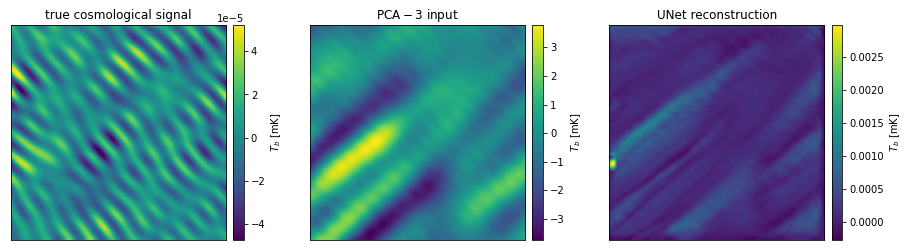

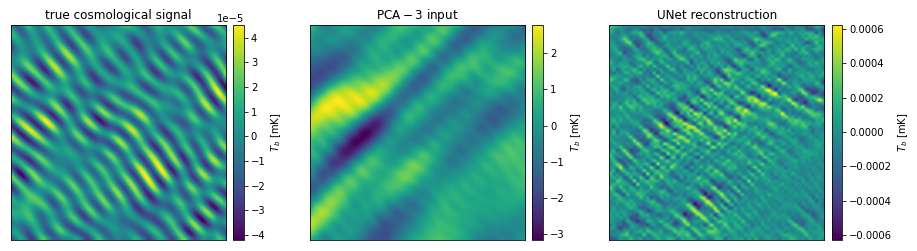

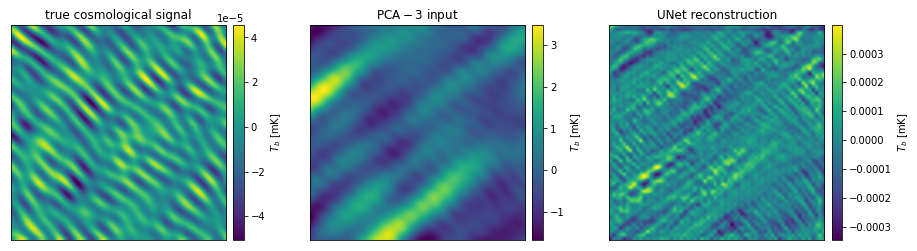

In [58]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

x_test = x_val
y_test = y_val

# actual frequencies
nutable = './deep21/sim_info/nuTable.txt'
(bn,nu_bot,nu_top,z_bot,z_top) = np.loadtxt(nutable).T
nu_arr = ((nu_bot + nu_top)/2.)[:-1]

# which frequencies we want to plot
nu_indx = [0, 32, 60]
for nu in nu_indx:
  pick = 0

  xval_c1 = np.squeeze(x_test)[pick].T 
  yval_c1 = np.squeeze(y_test)[pick].transpose() 
  y_c1_pred = np.squeeze(y_pred)[pick].transpose()

  fig,axs = plt.subplots(constrained_layout=True)

  ax1 = plt.subplot(131)
  im = ax1.imshow(yval_c1[nu], rasterized=True, 
                  interpolation='spline16')

  # create an axes on the right side of ax. The width of cax will be 5%
  # of ax and the padding between cax and ax will be fixed at 0.05 inch.
  divider = make_axes_locatable(ax1)
  cax = divider.append_axes("right", size="5%", pad=0.1)
  cbar = plt.colorbar(im, cax=cax)
  cbar.set_label(r'$T_b\ \rm [mK]$')
  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.set_title(r"true cosmological signal")


  ax1 = plt.subplot(132)
  im = plt.imshow(xval_c1[nu], rasterized=True, 
                  interpolation='spline16')

  # create an axes on the right side of ax. The width of cax will be 5%
  # of ax and the padding between cax and ax will be fixed at 0.05 inch.
  divider = make_axes_locatable(ax1)
  cax = divider.append_axes("right", size="5%", pad=0.1)
  cbar = plt.colorbar(im, cax=cax)


  cbar.set_label(r'$T_b\ \rm [mK]$')
  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.set_title(r"$\rm PCA-3 $ input")



  ax1 = plt.subplot(133)
  im = plt.imshow(y_c1_pred[nu], rasterized=True, 
                  interpolation='spline16')

  divider = make_axes_locatable(ax1)
  cax = divider.append_axes("right", size="5%", pad=0.1)
  cbar = plt.colorbar(im, cax=cax)

  cbar.set_label(r'$T_b\ \rm [mK]$')

  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.set_title(r"UNet reconstruction")


  #plt.suptitle(r'$\nu = $%03d'%(nu_arr[nu]) + r' $\rm MHz$')

  plt.gcf().set_size_inches((3.7* 3.37, 3.37))

  plt.show()

In [59]:
def angularPowerSpec(y_true, prediction, nu_select,
                     nu_arr, index_array, nu_avg=3):
    
    rearr = index_array
    nwinds = hp.nside2npix(4)

    # true map
    cosmo_test = (np.array_split(y_true, y_true.shape[0] // nwinds))

    # cleaned map
    y_pred = (np.array_split(prediction, prediction.shape[0] // nwinds))

    # residual map
    y_res = (np.array_split((prediction - y_true), y_true.shape[0] // nwinds))


    cosmo_Cl = []   # Cls for cosmo spectra
    pred_Cl  = []   # Cls for predicted spectra
    res_Cl   = []   # Cls for residual spectra
  
    for i,nu in enumerate(nu_select):
        
        # Get Cls for COSMO spectrum
        # loops over nsims test set skies
        cos = []
        for cosmo in cosmo_test:
            cosmo0 = (cosmo.T[nu].T).flatten()
            cosmo0 = cosmo0[rearr]
            alm_cosmo = hp.map2alm(cosmo0)
            Cl_cosmo = hp.alm2cl(alm_cosmo)
            cos.append(Cl_cosmo)
        
        # save average of Cl over nsims
        cosmo_Cl.append(np.mean(cos, axis=0))


        # Get Cls for the predicted maps
        predicted_cl = []
        for y in y_pred:
            y0 = (y.T[nu].T).flatten()
            y0 = y0[rearr]
            alm_y = hp.map2alm(y0)
            Cl_y = hp.alm2cl(alm_y)
            predicted_cl.append(Cl_y)

        # save average of Cl over nsims
        pred_Cl.append(np.mean(predicted_cl, axis=0))


        # Get Cls for the residual maps
        residual_cl = []
        for y in y_res:
            y0 = (y.T[nu].T).flatten()
            y0 = y0[rearr]
            alm_y = hp.map2alm(y0)
            Cl_y = hp.alm2cl(alm_y)
            residual_cl.append(Cl_y)

        # save average of Cl over nsims
        res_Cl.append(np.mean(residual_cl, axis=0))
 
        
    return np.array(cosmo_Cl), np.array(pred_Cl), np.array(res_Cl)

In [60]:
cosmo_target.shape

(192, 64, 64, 64)

In [65]:
pca3_prediction.shape

(192, 64, 64, 64)

In [61]:
%%time
#  squeeze out extra dims
unet_prediction = np.squeeze(y_pred)
cosmo_target = np.squeeze(y_test)
pca3_prediction = np.squeeze(x_test)

# which frequencies do we want to look at ? Let's do the same as the cutouts above
nu_indx = [0, 20, 60]

cosmo_cl, unet_cl, unet_res_cl = angularPowerSpec(cosmo_target, unet_prediction, 
                                                  nu_indx, nu_arr, index_arr)

cosmo_cl, pca3_cl, pca3_res_cl = angularPowerSpec(cosmo_target, pca3_prediction, 
                                                  nu_indx, nu_arr, index_arr)

TypeError: _astype() got an unexpected keyword argument 'order'

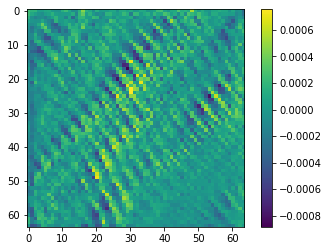

In [ ]:
plt.imshow(preds[0, :, :, 32])
plt.colorbar()

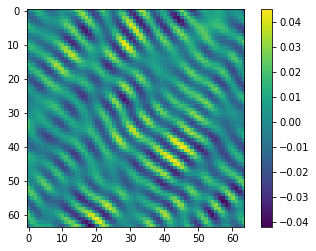

In [44]:
plt.imshow(y_val[0, :, :, 32] * 1000 )
plt.colorbar()

In [102]:
x_val.shape[0] / 12

16.0

In [113]:
i = 2
foo = np.arange(x_val.shape[0])
foo[i*batch_size:(i+1)*batch_size]

array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])